In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from collections import defaultdict
import json
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../../data/race_data/2020.csv')

In [4]:
new_times_lap = []
for index, time in df['Lap Time'].iteritems():
    if time.count(':') == 1:
        new_times_lap.append(datetime.strptime(time, '%M:%S.%f'))
    else:
        new_times_lap.append(datetime.strptime(time, '%H:%M:%S.%f'))
df['Lap Time'] = new_times_lap

In [5]:
new_times_s = []
date_index = 100000
for index, time in df['Session Time'].iteritems():
    if time.startswith('24') and time.count(':') > 1:
        date_index = index
        new_time = '01:00' + time[2:]
        new_date = datetime.strptime(new_time, '%d:%H:%M:%S.%f')
        new_date_plus = new_date + timedelta(days=1)
        new_times_s.append(new_date_plus)
    elif index > date_index:
        new_time = '01:00:0' + time
        new_date = datetime.strptime(new_time, '%d:%H:%M:%S.%f')
        new_date_plus = new_date + timedelta(days=1)
        new_times_s.append(new_date_plus)
    elif time.count(':') == 1:
        new_times_s.append(datetime.strptime(time, '%M:%S.%f'))
    else:
        new_times_s.append(datetime.strptime(time, '%H:%M:%S.%f'))
df['Session Time'] = new_times_s

In [6]:
df['Prev Session Time'] = df['Session Time'].subtract(df['Lap Time'])

In [7]:
for i in range(1,14):
    num_str = str(i)
    if i < 10: num_str = '0' + num_str
    num_str = 'S' + num_str
    
    vals = []
    for ind, split_time in df[num_str].iteritems():
        vals.append(timedelta(seconds=split_time))
    df[num_str] = vals
    totals = df[num_str] + df['Prev Session Time']
    
    for j in range(i-1, 0, -1):
        new_num_str = str(j)
        if j < 10: new_num_str = '0' + new_num_str
        new_num_str = 'S' + new_num_str
        totals += df[new_num_str]
    df[num_str+'totals'] = totals

In [29]:
df.to_csv('../../data/2020/2020_mod.csv', index=False, date_format='%Y-%m-%d %H:%M:%S.%f')

In [8]:
section_mod = defaultdict(list)
for index, row in df.iterrows():
    section_mod[row['Driver']].append((1, row['Prev Session Time'].total_seconds(), row['S01totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((2, row['S01totals'].total_seconds(), row['S02totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((3, row['S02totals'].total_seconds(), row['S03totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((4, row['S03totals'].total_seconds(), row['S04totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((5, row['S04totals'].total_seconds(), row['S05totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((6, row['S05totals'].total_seconds(), row['S06totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((7, row['S06totals'].total_seconds(), row['S07totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((8, row['S07totals'].total_seconds(), row['S08totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((9, row['S08totals'].total_seconds(), row['S09totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((10, row['S09totals'].total_seconds(), row['S10totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((11, row['S10totals'].total_seconds(), row['S11totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((12, row['S11totals'].total_seconds(), row['S12totals'].total_seconds(), row.Car, row.SPI))
    section_mod[row['Driver']].append((13, row['S12totals'].total_seconds(), row['S13totals'].total_seconds(), row.Car, row.SPI))

In [9]:
MAXTIME = df['S13totals'].max().total_seconds()
def roundTo(x, base=20):
    return base * round(x/base)
MAXTIME = roundTo(MAXTIME, 20)

In [10]:
pit_times = {}
for car in list(pd.unique(df.Car)):
    df_car = df.loc[(df['Car'] == car) & (df['Location'] == 'Pit')]
    pt = list(pd.unique(df_car['Session Time']))
    d_zero = np.datetime64('1900-01-01T00:00:00')
    pt = [(d - d_zero) / np.timedelta64(1, 's') for d in pt]
    pt = [0] + pt
    pit_times[car] = pt

In [11]:
flagtimes = [27940, 36360, 65440, 68460, 70540]

In [12]:
def getLastPit(car, time):
    lp = max([t for t in pit_times[car] if t <= time])
    return (time - lp) / 60

avg_pit = {}
for k, v in pit_times.items():
    diffs = [j-i for i, j in zip(v[:-1], v[1:])]
    avg_pit[k] = np.average(diffs) / 60
    
aplist = [k for k,v in sorted(avg_pit.items(), key=lambda t: t[1], reverse=True)]
pos_dict = {}
for i in range(len(aplist)):
    pos_dict[aplist[i]] = i+1

print(pos_dict[38], avg_pit[38], getLastPit(38, 27940) )
print(pos_dict[19], avg_pit[19], getLastPit(19, 36360) )
print(pos_dict[74], avg_pit[74], getLastPit(74, 65440) )
print(pos_dict[19], avg_pit[19], getLastPit(19, 68460) )
print(pos_dict[47], avg_pit[47], getLastPit(47, 70540) )

33 34.841777916666665 8.67546666666664
2 59.89226929824562 18.676083333333374
7 51.781035802469134 61.685516666666686
2 59.89226929824562 3.046883333333244
5 52.652204545454545 17.31816666666661


In [13]:
def get_risk_score(x):
    alpha = 4
    beta = 1.3
    MEAN1 = 0
    MEAN2 = 45.25483333333322
    STD1 = 15.610617771584481
    STD2 = 9.909181352955741
    return (alpha*norm.pdf(x, MEAN1, STD1) + beta*norm.pdf(x, MEAN2, STD2))*10

In [33]:
risk_score = {}
sus_score = {}
for t in range(0, MAXTIME, 300):
    agg_risk = 0
    agg_sus = 0
    for car in pit_times:
        lp = getLastPit(car, t)
        
        previous = [time for time in pit_times[car] if time <= t]
        pt = 0
        sus = 0
        for p in previous[1:]:
            if p - pt < 600:
#                 print(previous)
                sus += 100
            elif p - pt < 900:
                sus += 80
            elif p - pt < 1500:
                sus += 30
            else:
                sus -= .25
            pt = p
        agg_sus += sus
        
        agg_risk += get_risk_score(lp) 
    risk_score[t] = agg_risk
    sus_score[t] = agg_sus

In [34]:
sus_deriv = {}
for t in range(300, MAXTIME, 300):
    sus_deriv[t] = (sus_score[t] - sus_score[t-300]) / 300

In [35]:
rounded_times = [(t // 300 * 300) + 300 for t in flagtimes]
for t in rounded_times:
#     print(risk_score[t])
    risk_score[t] = 0
    risk_score[t+300] = 0
#     print(sus_score[t])
    sus_score[t] = 0
    sus_score[t+300] = 0
    sus_deriv[t] = 0
    sus_deriv[t+300] = 0

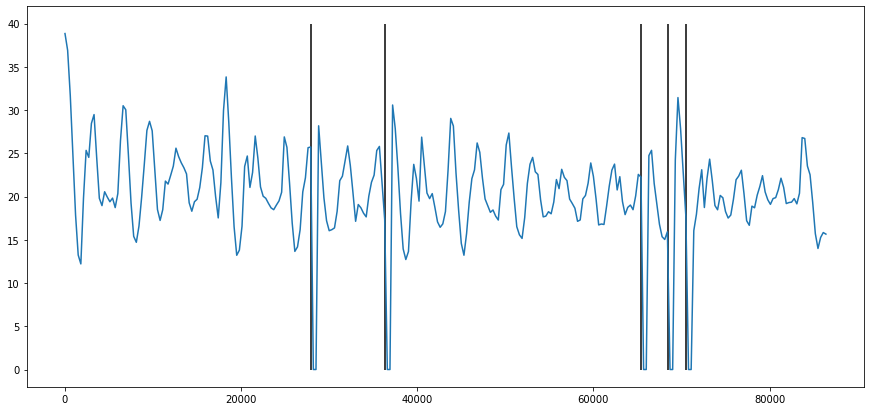

In [36]:
plt.figure(figsize=(15,7))
plt.plot(list(risk_score.keys()), list(risk_score.values()))
plt.vlines(flagtimes, 0, 40)
plt.show()

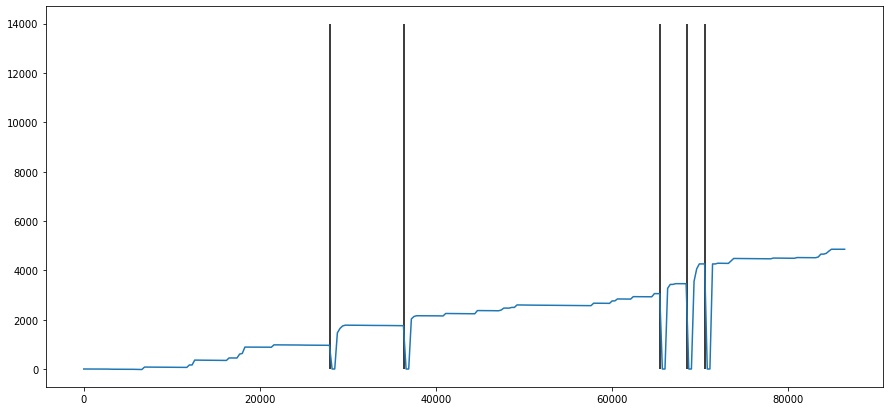

In [37]:
plt.figure(figsize=(15,7))
plt.plot(list(sus_score.keys()), list(sus_score.values()))
plt.vlines(flagtimes, 0, 14000)
plt.show()

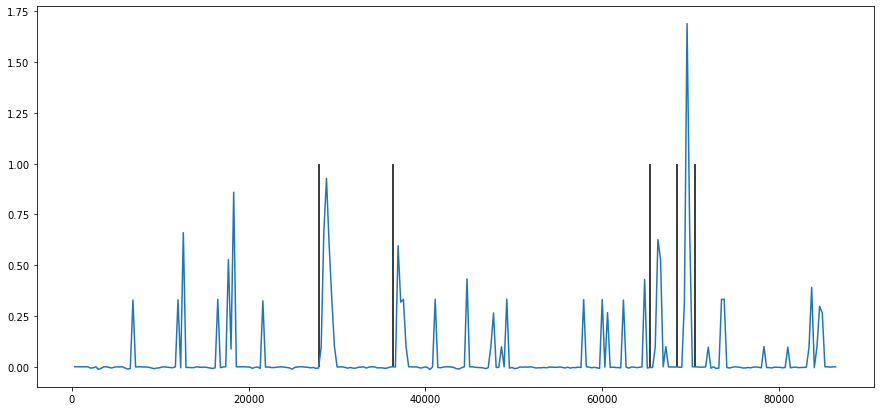

In [30]:

plt.figure(figsize=(15,7))
plt.plot(list(sus_deriv.keys()), list(sus_deriv.values()))
plt.vlines(flagtimes, 0, 1)
plt.show()

In [31]:
with open('../../data/2020/20_risk_score.csv', 'w') as f:
    f.write('Time,Risk Score\n')
    for k,v in risk_score.items():
        f.write('%s,%s\n'%(k,v))

OSError: [Errno 28] No space left on device

In [58]:
with open('../../data/2020/20_sus_deriv.csv', 'w') as f:
    f.write('Time,Sus Deriv\n')
    for k,v in sus_deriv.items():
        f.write('%s,%s\n'%(k,v))

In [12]:
cars = [38, 19, 74, 19, 47]
times = [27940, 36360, 65440, 68460, 70540]
stopped_pit = [(t[0], t[1], getLastPit(t[0], t[1])) for t in zip(cars, times)]

with open('../../data/2020/20_stopped_car_pit.csv', 'w') as f:
    f.write('Car,Flag Time,Last Pit\n')
    for s in stopped_pit:
        f.write("%s,%s,%s\n"%(s[0], s[1], s[2]))

In [ ]:
# stopped cars: [47, 19, 74, 19, 38]

In [11]:
# last_pit = {}
# for t in range(20, MAXTIME, 20):
#     all_times = []
#     for car in pit_times.keys():
#         lp = max(filter(lambda pt: pt < t, pit_times[car]))
#         all_times.append(t - lp)
#     last_pit[t] = np.average(all_times) / 60

In [14]:
distances = {1: 1876, 2: 1751.33, 3: 1768.67, 4: 2352, 5: 1488, 6: 1475, 7: 1427, 
             8: 1428, 9: 1457, 10: 1484, 11: 1283, 12: 120, 13: 886.83}

num_drivers = defaultdict(lambda: defaultdict(list))
concentration = defaultdict(lambda: defaultdict(float))
last_pit = {}
avg_speed = {}
for t in range(20, MAXTIME, 20):
    cars = []
    speeds = []
    for driver in section_mod:
        for interval in section_mod[driver]:
            if interval[1] <= t <= interval[2]:
                num_drivers[t][interval[0]].append((interval[1], interval[2]))
                cars.append(interval[3])
                speeds.append(interval[4])
                break
    for section in num_drivers[t]:
        concentration[t][section] = (len(num_drivers[t][section]) / distances[section]) * 1000
        # cars per 1000 feet
    
    all_times = []
    for car in cars:
        lp = max(filter(lambda pt: pt < t, pit_times[car]))
        all_times.append(t - lp)
    last_pit[t] = np.max(all_times) / 60
    avg_speed[t] = np.average(speeds)

In [15]:
with open('../../data/2020/20_num_drivers.json', 'w') as outfile:
    json.dump(num_drivers, outfile)
with open('../../data/2020/20_concentrations.csv', 'w') as f:
    f.write('Time,Sector,Concentration\n')
    for time in concentration.keys():
        for sector in range(1,14):
            f.write("%s,%s,%s\n"%(time, sector, concentration[time].get(sector, 0)))

In [16]:
with open('../../data/2020/20_time_since_pit.csv', 'w') as f:
    f.write('Time,Last Pit\n')
    for time, lp in last_pit.items():
        f.write("%s,%s\n"%(time, lp))

In [18]:
with open('../../data/2020/20_avg_speed.csv', 'w') as f:
    f.write('Time,Speed\n')
    for time, speed in avg_speed.items():
        f.write("%s,%s\n"%(time, speed))